# 2017-10-06  Convex optimisation

The goal of this lab is to manipulate some of the convex optimisation tools from [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html), which you will need to implement the machine learning algorithms we will see in the course.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, set_matplotlib_formats 
set_matplotlib_formats('pdf', 'svg') # toggle vector graphics for a crisp plot!

## Introduction

Convex functions have the useful property that local minima are global minima.
![](./img/convexity.png)

To get a feel for scipy, we start with a simple example. We begin by defining a function to optimise, $$f_1(x) = (x - 1)^4 + x^2$$

In [2]:
# specify objective function
f1 = lambda x : (x - 1) ** 4 + x ** 2

We use Brent's method for optimisation. Brent's method does not require the function to optimize to be convex or derivable everywhere, and works as a combination of the secant method and parabola fittings, as follows:
1. Take a, b such that f'(a) < 0 and f'(b) > 0
2. Repeat:
  * Compute c = (a+b)/2
  * Compute the point d where the parabola that goes through a, b and c is minimal
  * If f'(d) < 10^{-sthg}: stop
  * Otherwise if f'(d) < 0: replace a with d, otherwise: replace b with d.
  
<img src="./img/brent.png", width=600>

Illustration's source: Press, W. H., et al. (1992) "Numerical Recipes in Fortran, The Art of Scientific Computing", Cambridge University Press, Chapter 10.

In [3]:
from scipy.optimize import minimize_scalar

res = minimize_scalar(f1, method='brent')
print('xmin: %.02f, fval: %.02f, iter: %d' % (res.x, res.fun, res.nit))

xmin: 0.41, fval: 0.29, iter: 12


**Question:** Briefly describe the function output.

**Answer:** It is the value of x that minimizes the function, the value of the function in that point and the number of iterations that the algorithm has repeated.

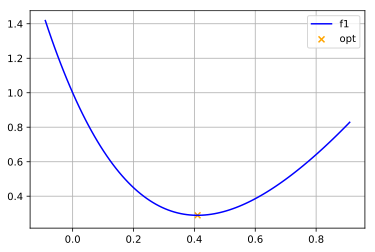

In [4]:
# plot curve
x = np.linspace(res.x - 0.5, res.x + 0.5, 100)
y = [f1(val) for val in x]
plt.plot(x, y, color='blue', label='f1')

# plot optima
plt.scatter(res.x, res.fun, color='orange', marker='x', label='opt')

plt.grid()
plt.legend(loc=1)

**N.B.** Optimisation, and particularly convex optimisation, plays a central role in machine learning. Although in this lab we focus on optimising simple functions, the same techniques will be used to optimise the high-dimensional loss functions of our learning machines.

#### Utility functions

In the following, we will be doing a lot of plotting, so we'll create a reusable function:

In [5]:
def plot_iterations(f, iterations, delta=0.1, box=1):
    xs = np.arange(-box, +box, delta)
    ys = np.arange(-box, +box, delta)
    X, Y = np.meshgrid(xs, ys)
    # create function mesh
    Z = np.array([[f(np.array([x, y])) for x in xs] for y in ys])   #crea array della funzione
    # contour plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    cd = ax.contour(X, Y, Z)
    # error plot
    ax.clabel(cd, inline=1, fontsize=10)
    ax.plot(iterations[:, 0], iterations[:, 1], color='red', marker='x', label='opt')
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(range(len(iterations)), [f(np.array(step)) for step in iterations], 'xb-')
    ax.grid('on')
    ax.set_xlabel('iteration')
    ax.set_xticks(range(len(iterations)))
    ax.set_ylabel('f(x)')

__Question:__ What does `plot_iterations` do?

__Answer:__  crea un grafico 

We'll also need a callback function between iterations. This function will be called after each iteration.

In [8]:
# specify callback function
def get_callback_function(data_list):
    def callback_function(x):
        data_list.append(x)
    return callback_function         #x is an element of the datalist (we only give x)

In [9]:
#cb_fun=get_callback_function(dl)
#cb_fun(58)
#cb_fun(93)

## Smooth functions

When our cost function is smooth, we can use the tools of calculus for an open or closed-formed solution. We here focus on the former case, where our function is optimised incrementally in an iterative procedure. In general, we iterate until the gradient of our function is close to zero. We again start by specifing a function to minimise,

\begin{align}
f_2(\mathbf{x}) &= 2x_1^2 + 5x_2^2 \\ \notag
&= \mathbf{x}^T\mathbf{D}\mathbf{x} \notag
\end{align}

where $\mathbf{D} = \begin{bmatrix}
    2 & 0 \\
    0 & 5 \end{bmatrix}$ and $\mathbf{x} \in \mathbb{R}^{2}$.

In [16]:
f2 = lambda x : x.T.dot(np.diag([2, 5])).dot(x)


#def get_f2(): #get_f2=lambda
   # def f22(x):
     #   return x.T.dot(np.diag([2, 5])).dot(x)
   # return f22

### Brute force search

First we'll try a trivial optimisation algorithm: [brute force](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html#scipy.optimize.brute). A brute force search tries every point in a fixed grid and retains the minimising value.

In [15]:
from scipy.optimize import brute
print(brute(f2, ranges=((-2, 2), (-2, 2))))  #x1 e x2 da -2 a 2

#lambda è come get_callback_function
#f2 è come callback_function

[  1.51252956e-05  -1.18367293e-07]


**Question:** Comment briefly on the output.

**Answer:** It represents the coordinates of the point X1, X2 at which f2 has its minimum value

### First and second-order characterizations

A twice-differentiable convex function has a positive semi-definite Hessian $\mathbf{x} \mapsto \nabla^2 f(\mathbf{x})$ and is minimized where the gradient $\mathbf{x} \mapsto \nabla f(\mathbf{x})$ is equal to 0.

**Question:** Write a function `df2()` for the Jacobian (vector of partial derivatives) of `f2()` below:

In [23]:
def df2(x):
    # TODO: return vector of partial derivatives
    return (np.diag([2,5]) + np.diag([2,5]).T).dot(x)


**Question:** Write a function `ddf2()` for the Hessian (matrix of second partial derivatives) of `f(2)` below:

In [24]:
def ddf2(x):
    # TODO: return Hessian matrix of second partial derivatives 4
    return (np.diag([2,5]) + np.diag([2,5]).T)
    


**Question:** Prove our Hessian matrix, $\mathbf{H} = \partial^2 f / \partial\mathbf{x}^2$, is positive-definite everywhere.

**Answer:** 1)xTHx is positive for every x different from 0
            2) all eigenvalues are positive

### Gradient descent methods

The workhorse of machine learning is gradient descent. Its variants are used to optimise a panoply of models from linear regression to deep neural nets. The gradient of mulivariate function at a point is the vector normal to the level curve. Gradient descent works by taking steps in the direction of the gradient,

$$\mathbf{x}_{k+1} = \mathbf{x}_{k} -\alpha\nabla f(\mathbf{x_k})$$

![Gradient descent on a 2D convex function](img/gd.png)

#### Newton's Method

Newton's method is a second order method, minimising a quadratic Taylor approximation to the objective function at each point. It thus combines the gradient and Hessian matrix,

$$\mathbf{x}_{k+1} = \mathbf{x}_{k} -\alpha\mathbf{H}_k^{-1}\mathbf{g}_k$$

where $\mathbf{g}_k = \nabla f(\mathbf{x_k})$ and $\mathbf{H}_k = \nabla^2 f(\mathbf{x_k})$. This is a multi-dimensional generalisation of the Newton root-finding method (here we are finding the root of the gradient). Newton's method typically involves a line search to optimise the size of the descent step, $\alpha$.

**Question:** Fill in the missing lines in the cell below to run [Newton's method](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_ncg.html) on our function. Note, in this implementation, the (sparse) Hessian is inverted by conjugate gradient descent.

In [53]:
# import                                                             #FARE 
# TODO 
from scipy.optimize import fmin_ncg

# specify initial point
x0 = [-1, 1]
# initialise callback data
ncg_data = [np.array(x0)]
# use fmin_ncg
# TODO
trash,new_ncg_data = fmin_ncg(f2, ncg_data ,df2,fhess=ddf2,retall=True)


print ncg_data
print new_ncg_data


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 14
         Hessian evaluations: 7
[array([-1,  1])]
[array([-1,  1]), array([-0.56390977, -0.09022556]), array([-0.09667025,  0.09667025]), array([-0.0545133 , -0.00872213]), array([-0.00934514,  0.00934514]), array([-0.00526981, -0.00084317]), array([  0.00000000e+00,  -1.08420217e-19]), array([  0.00000000e+00,  -1.08420217e-19])]


In [57]:
type(np.array(0)) #see documentation

numpy.ndarray

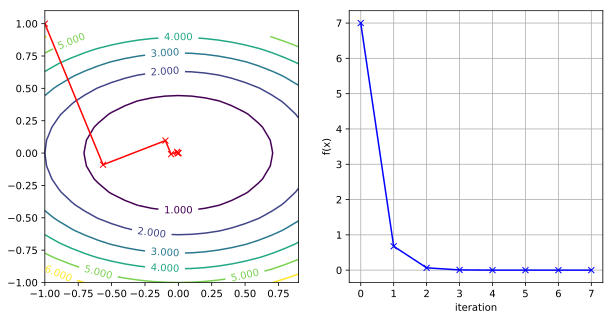

In [54]:
plot_iterations(f2, np.array(new_ncg_data))

**Question:** Newton's method uses a line search to optimise each descent step by choosing a step size $\alpha$ that optimises the descent direction, that is, $$\min_\alpha f(\mathbf{x_k} + \alpha \mathbf{d}_k),$$ where $\mathbf{d}_k = \nabla f({\mathbf{x}_k})$ is the descent direction. How does this show in the visualisation?

**Answer:**

#### Quasi-Newton: BFGS

[Broyden–Fletcher–Goldfarb–Shanno (BFGS)](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) is a quasi-Newton method. Because the Hessian is $\mathcal{O}(n^2)$ (a large expense at each iteration), BFGS aims to approximate the Hessian "on the fly" as a sum of rank one approximations. Note when space *and* runtime are a concern, *limited-memory* BFGS (l-BFGS) is further an option.

**Question:** Run the [scipy BFGS](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html#scipy.optimize.fmin_bfgs) algorithm on our function.

In [58]:
# initialise callback data
bfgs_data =[np.array(x0)] # TODO

# TODO 
from scipy.optimize import fmin_bfgs
_,new_bfgs_data=fmin_bfgs(f2,bfgs_data, retall=True)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 24
         Gradient evaluations: 6


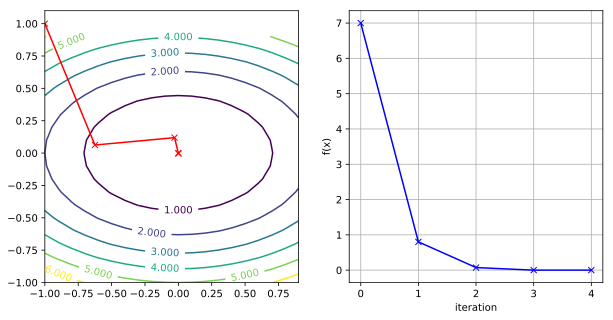

In [60]:
plot_iterations(f2, np.array(new_bfgs_data))

**Question:** Verify that the norm of the gradient at the final point is close to 0.

In [ ]:
# TODO calculate the norm of the gradient

**Question:** What do you observe about the steps?

**Answer:** 

#### Conjugate gradient method

The [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) is an alternative to gradient descent. For a linear system $\mathbf{A}\mathbf{x} = \mathbf{b}$, this algorithm finds a solution as a linear combination of a set of *mutually conjugate vectors*, $\mathbf{p}_d$, such that,

$$\mathbf{x}^* = \sum_{d=1}^D \alpha_d\mathbf{p}_d$$ for the $D$ dimensions of the problem. The vectors are built determined one by one in a process similar to the [Gram Schmidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process). Particularly for a sparse system, a good approximate solution can be determined without constructing the entire conjugate set.

__Question:__ Run the conjugate gradient method `fmin_cg` on our function.

In [ ]:
# initialise callback data
cg_data = # TODO

# TODO

In [ ]:
plot_iterations(f2, np.array(cg_data))

**Question:** Try changing the initial point. Does anything change? Why?

**Answer:** 

## Non-smooth functions

Convex functions remain convex when we add linear constraints. A linear constraint restricts the solution space with an intersecting hyperplane. However, the smoothness property is lost, and calculus is no longer an option. To conceptualise the effect, imagine taking a spherical fruit such as an apple to be our unconstrained convex function. Then, adding a linear constraint corresponds to slicing it at some position at a fixed angle. Intuitively, the fruit remains convex after the cut, despite losing its smoothness (roundness).

#### Quadratic programming

A [quadratic programming (QP) problem](https://en.wikipedia.org/wiki/Quadratic_programming) is an optimisation problem of a quadratic function $\frac{1}{2}\mathbf{x^TQx} + \mathbf{c^Tx}$ subject to linear constraints, $\mathbf{Ax} \leq \mathbf{b}$. QP optimisation algorithms can be applied to the training of support vector machines (SVMs). Let's optimise the following quadratic program:

$$
\begin{array}{rl}
\text{minimise} & z = x_1^2 + 4x_2^2 - 32x_2 + 64 \\
\text{subject to} & x_1 + x_2 \leq 7 \\
& -x_1 + 2x_2 \leq 4 \\
& x_2 \leq 4 \\
& x_1, x_2 \geq 0
\end{array},
$$



**Question:** Specify the constraint matrices, $\mathbf{A}$ (coefficients), and $\mathbf{b}$ (constants).

In [ ]:
# specify the matrix of coefficients
A = #TODO 

# specify the vector of constants
b = #TODO

We create dictionary of constraints for use in the optimisation function:

In [ ]:
cons = {'type':'ineq',
        'fun':lambda x: b - np.dot(A,x),
        'jac':lambda x: -A}

**Question:** Next, specify the components of the objective function: the matrix of quadratic coefficients $\mathbf{Q}$, the vector of linear coefficients $\mathbf{c}$, and the constant term, $c_0$.

In [ ]:
# specify the matrix of quadratic coefficients
Q = # TODO

# specify the vector of linear coefficients
c = # TODO 

# specify the constant
c0 = # TODO

**Question:** Write the objective function (loss).

In [ ]:
def loss(x):
    # TODO: return loss (= objective function) given x
    

**Question:** Write the Jacobian function.

In [ ]:
def jac(x):
    # TODO: return vector of partial derivatives
    

**Question:** Run scipy.optimize's minimize function on our QP problem.

In [ ]:
from scipy.optimize import minimize

x0 = np.random.randn(2)
opt = {'disp':False}
res_cons = minimize(loss, x0, jac=jac, constraints=cons, method='SLSQP', options=opt)

print('\nConstrained:')
print(res_cons)

x1, x2 = res_cons['x']
f = res_cons['fun']

Finally, we will plot the solution in 3D axes. Feel free to change the code to adjust the view.

In [ ]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
# plotting
xgrid = np.mgrid[-2:4:0.1, 1.5:5.5:0.1]
xvec = xgrid.reshape(2, -1).T
F = np.vstack([loss(xi) for xi in xvec]).reshape(xgrid.shape[1:])

ax = plt.axes(projection='3d')
ax.hold(True)
ax.plot_surface(xgrid[0], xgrid[1], F, rstride=1, cstride=1,
                cmap=plt.cm.jet, shade=True, alpha=0.9, linewidth=0)
ax.plot3D([x1], [x2], [f], 'og', mec='w', label='Constrained minimum')
ax.legend(fancybox=True, numpoints=1)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('F')

#### To go further: Linear programming

We begin by defining a linear program, a linear function, $\mathbf{c}^T\mathbf{x}$ subject to linear constraints $\mathbf{A}\mathbf{x} \leq \mathbf{b}$:

$$
\begin{array}{rl}
\text{minimise} & z = -2x_1 - x_2 \\
\text{subject to} & x_1 + x_2 \leq 5 \\
& 5x_1 + 2x_2 \leq 10 \\
& x_1, x_2 \geq 0
\end{array},
$$

**Question:** Initialise the matrix $\mathbf{A}$ and the vectors $\mathbf{b}$ and $\mathbf{c}$.

In [ ]:
# TODO Initialise A, b, and c as numpy arrays


Linear programs can be solved efficiently with the [Simplex algorithm](https://en.wikipedia.org/wiki/Simplex_algorithm). The program specifies an N-dimensional convex solid, and the algorithm works by moving along the edges of this shape from corner to corner. As any optimal solution must be on the surface, we can discard all points interior to the solid. This reduces the feasible solution space to a finite set. Furthermore, the convexity of the solid guarantees that as long as we repeatedly take upward steps along the surface edges, we will arrive at a maximum in a finite number of steps.

![Linear Program](img/lp.png)

**Question:** Solve the linear program using [scipy's implementation of Simplex](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html).

In [ ]:
# TODO: solve the linear program


**N.B.** Scipy doesn't really support proper QP solvers. When we come to support vector machines, we will implement the solver ourselves.